Before we begin, we will change a few settings to make the notebook look a bit prettier:

In [1]:
%%html
<style> body {font-family: "Calibri", cursive, sans-serif;} </style>

<img src="../images/pokeball.png" width="100" align="right">

# Visualization of the<br> Favorite Pok&eacute;mon Survey Results
---
In this notebook, I will generate different visualizations of the [Favorite Pok&eacute;mon Survey](<https://www.reddit.com/r/pokemon/comments/c04rvq/survey_testing_the_every_pok%C3%A9mon_is_someones/>) results. The data was collected and made public by [reddit user mamamia1001](https://www.reddit.com/user/mamamia1001/). Full credit goes to him/her. I will also be including a few comments on the results and how I interpret them. For more info, take a look at the [README file](../README.md). 

Alright, let's get started.


# Preliminaries
First, let's import all the relevant packages, configure some plotting options, and define some basic (path) variables.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pathlib
from PIL import Image
import requests
from io import BytesIO

import pokefunctions

In [2]:
mpl.rcParams['font.sans-serif'] = 'Calibri'
mpl.rcParams['font.family'] = 'sans-serif'
sns.set(font_scale=1.75)
sns.set(font = 'Calibri')
sns.set_style('ticks')

plt.rc('axes.spines', top=False, right=False)

# Control font sizes.
plt.rc('font', size=12) # Default text size
plt.rc('axes', titlesize=16) # Axes title
plt.rc('axes', labelsize=16) # x and y labels
plt.rc('xtick', labelsize=12) # x tick labels
plt.rc('ytick', labelsize=12) # y tick labels
plt.rc('legend', fontsize=12) # Legend
plt.rc('figure', titlesize=16) # Figure title

In [3]:
# Define paths.
PATH_DATA = pathlib.Path(r'../data')
PATH_IMAGES = pathlib.Path(r'../images')

# Read data
I [downloaded a copy](../data) of the [original results](https://docs.google.com/spreadsheets/d/1c16Wh4AawHGbTi3Eq1DGZQdM4FMUlJO1YwXJZ_ylRvg/edit#gid=557303698) as an Excel file. Let's read just the relevant parts:

In [4]:
df = pd.read_excel(PATH_DATA/'responses.xlsx', sheet_name='Results', usecols='A:E')
df.rename(columns={'Results in full':'name', 'Unnamed: 1':'votes', 'Unnamed: 2':'types', 'Unnamed: 3':'generation', 'Unnamed: 4':'family'}, inplace=True)

# Shift the index by 1, so that it matches the Pokemon number.
df.index = df.index + 1

# Remove any potential NaN.
df.dropna(inplace=True)

# Make sure generation is int.
df['generation'] = df['generation'].astype(int)

df.head(3)

,name,votes,types,generation,family
1,Bulbasaur,710.0,Grass Poison,1,Bulbasaur
2,Ivysaur,83.0,Grass Poison,1,Bulbasaur
3,Venusaur,127.0,Grass Poison,1,Bulbasaur


# Original Analysis
As a sanity check, let's (re)compute the already reported numbers.

### Number of valid votes
Original result: 52725

From the aggregated results:

In [6]:
n_votes = df['votes'].sum()
print(n_votes)

52725.0


### Average votes per Pok&eacute;mon
Original result: 65

In [7]:
n_pokemon = len(df['name'].unique())
print(n_votes/n_pokemon)

65.17305315203956


### Average votes per Pok&eacute;mon per generation

In [8]:
df_votes_generation = df.groupby(['generation']).mean()
print(df_votes_generation)

                 votes
generation            
1           121.119205
2            91.150000
3            70.140741
4            70.383178
5            28.147436
6            29.916667
7            20.181818


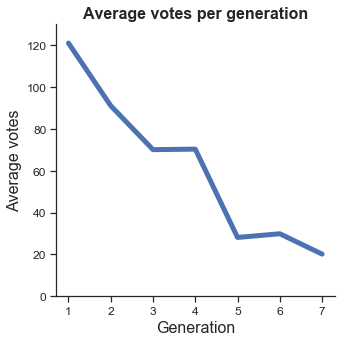

In [19]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
ax.plot(df_votes_generation.index, df.groupby(['generation']).mean()['votes'], linewidth=5)
ax.set_xticks(df_votes_generation.index)
ax.set_ylim((0, 130))
ax.set_title("Average votes per generation", fontdict = {'weight':'bold'})
ax.set_xlabel("Generation")
ax.set_ylabel("Average votes")
fig.savefig(PATH_IMAGES/'generation_average.png', dpi=1000, bbox_inches='tight')
plt.show();


Generation colors were taken from [Bulbapedia](https://bulbapedia.bulbagarden.net/wiki/Generation).

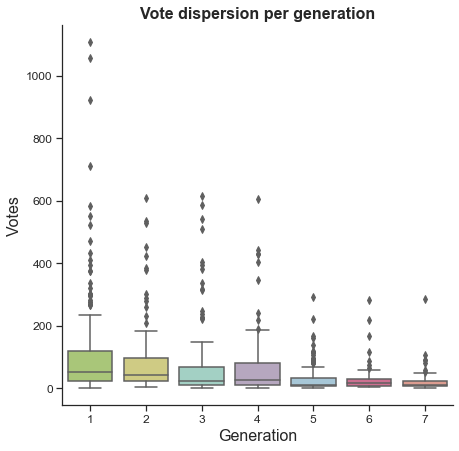

In [21]:
generation_palette = {1:'#ACD36C', 
                      2:'#DCD677', 
                      3:'#9CD7C8', 
                      4:'#B7A3C3', 
                      5:'#9FCADF', 
                      6:'#DD608C', 
                      7:'#E89483'}

fig, ax = plt.subplots(1, 1, figsize=[7, 7])
sns.boxplot(x='generation', y='votes', data=df, ax=ax, palette=generation_palette)
ax.set_title("Vote dispersion per generation", fontdict = {'weight':'bold'})
ax.set_xlabel("Generation")
ax.set_ylabel("Votes")
fig.savefig(PATH_IMAGES/'generation_boxplot.png', dpi=1000, bbox_inches='tight')
plt.show();

The outliers show us Pok&eacute;mon with a high number of votes. As we will see in a second, it is clear that no Pok&eacute;mon from generations 5, 6, or 7 cracks the top preference spots.

### Pok&eacute;mon ranking
Sort Pok&eacute;mon from most to least popular:

In [23]:
df_sorted = df.sort_values('votes', ascending=False)

The top 10 (most popular) Pok&eacute;mon:

In [12]:
df_sorted.head(10)

,name,votes,types,generation,family
6,Charizard,1107.0,Fire Flying Dragon,1,Charmander
94,Gengar,1056.0,Ghost Poison,1,Gastly
59,Arcanine,923.0,Fire,1,Growlithe
1,Bulbasaur,710.0,Grass Poison,1,Bulbasaur
257,Blaziken,613.0,Fire Fighting,3,Torchic
197,Umbreon,607.0,Dark,2,Eevee
448,Lucario,604.0,Fighting Steel,4,Riolu
282,Gardevoir,585.0,Psychic Fairy,3,Ralts
133,Eevee,581.0,Normal,1,Eevee
149,Dragonite,551.0,Dragon Flying,1,Dratini


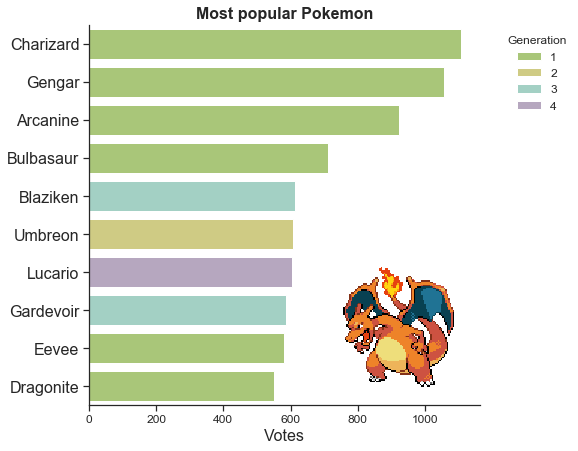

In [24]:
fig, ax = plt.subplots(1, 1, figsize=[7, 7])
sns.barplot(x=df_sorted.head(10)['votes'], y=df_sorted.head(10)['name'], hue='generation', palette=generation_palette, dodge=False, data=df_sorted.head(10), ax=ax)
pokemon_image = pokefunctions.get_sprite(df_sorted.index[0])
if pokemon_image != None:
    ax_ins = inset_axes(ax, width=2, height=2, loc='lower right')
    ax_ins.imshow(pokemon_image)
    ax_ins.axis('off')
ax.set_title("Most popular Pokemon", fontdict={'weight':'bold'})
ax.set_xlabel("Votes")
ax.set_ylabel("")
ax.yaxis.set_tick_params(labelsize=16)
ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.25, 1)).set_title("Generation")
fig.savefig(PATH_IMAGES/'popular.png', dpi=1000, bbox_inches='tight')
plt.show();

Now we know who were those outliers from earlier ;) .

### Pok&eacute;mon ranking by family
The top 10 (most popular) Pok&eacute;mon *families*:

In [25]:
df_families = df[['votes', 'family']].groupby(['family']).sum().sort_values('votes', ascending=False).head(10)
df_families

,votes
family,
Eevee,2865.0
Charmander,1551.0
Gastly,1384.0
Growlithe,1199.0
Cyndaquil,1092.0
Squirtle,1066.0
Ralts,924.0
Bulbasaur,920.0
Scyther,818.0


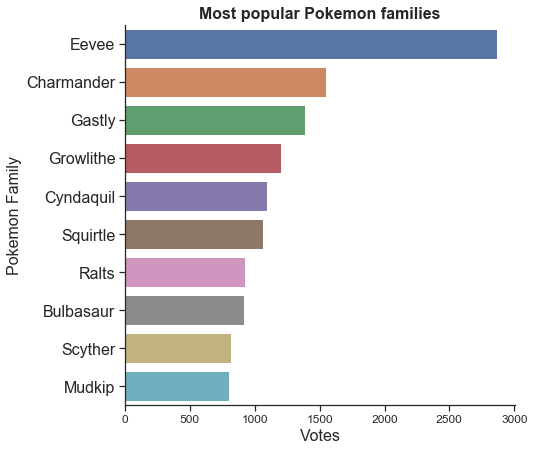

In [26]:
fig, ax = plt.subplots(1, 1, figsize=[7, 7])
sns.barplot(x=df_families['votes'], y=df_families.index, data=df_families, ax=ax)
ax.set_title("Most popular Pokemon families", fontdict={'weight':'bold'})
ax.set_xlabel("Votes")
ax.set_ylabel("Pokemon Family")
ax.yaxis.set_tick_params(labelsize=16)
fig.savefig(PATH_IMAGES/'popular_family.png', dpi=1000, bbox_inches='tight')
plt.show();

### Pok&eacute;mon ranking by generation
The most popular Pok&eacute;mon of each generation:

Text(0.5, 1.0, 'Most popular Pokemon of each generation')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

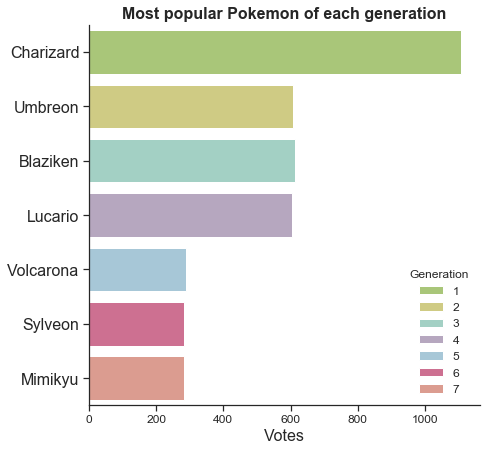

(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular Pokemon of generation 1')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

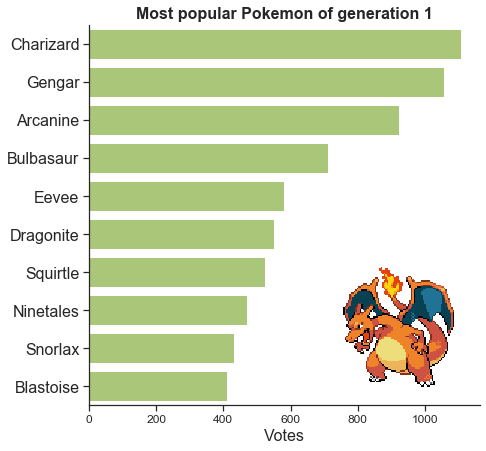

(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular Pokemon of generation 2')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

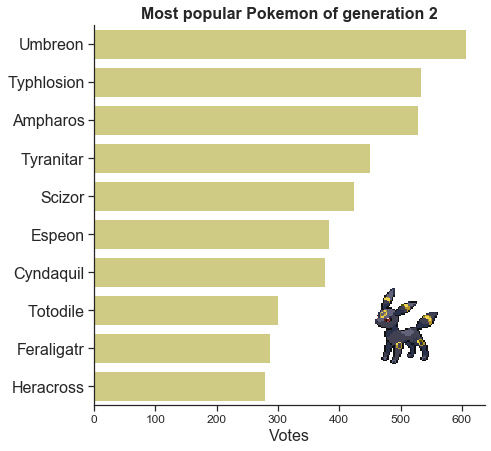

(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular Pokemon of generation 3')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

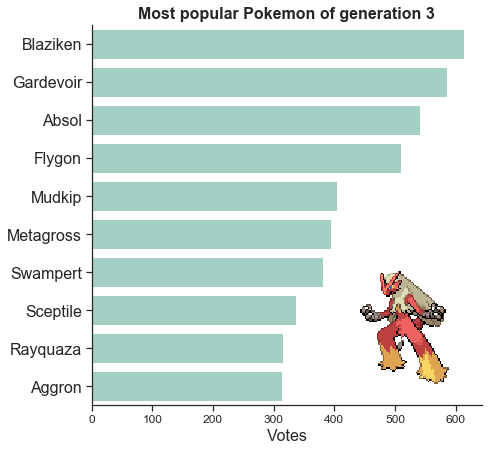

(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular Pokemon of generation 4')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

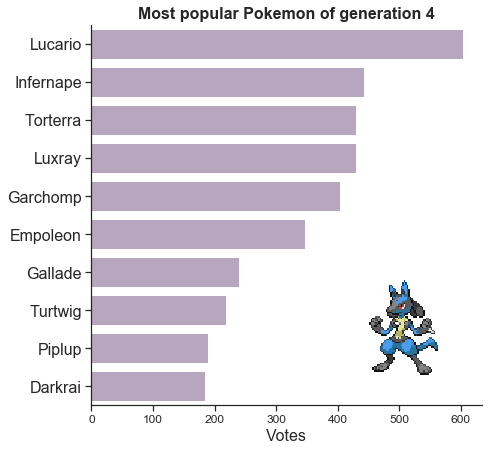

(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular Pokemon of generation 5')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

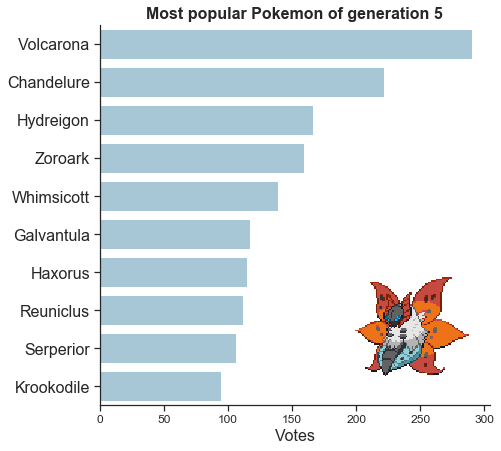

(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular Pokemon of generation 6')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

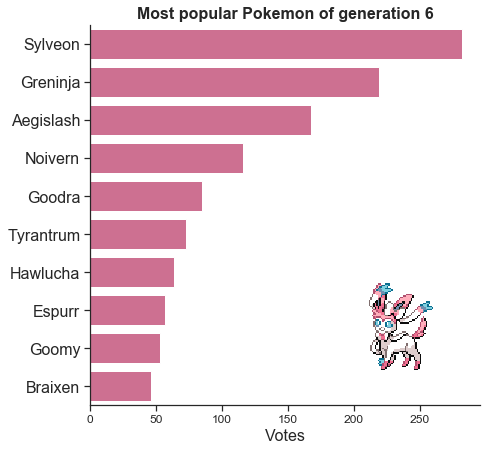

(-0.5, 127.5, 127.5, -0.5)

Text(0.5, 1.0, 'Most popular Pokemon of generation 7')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

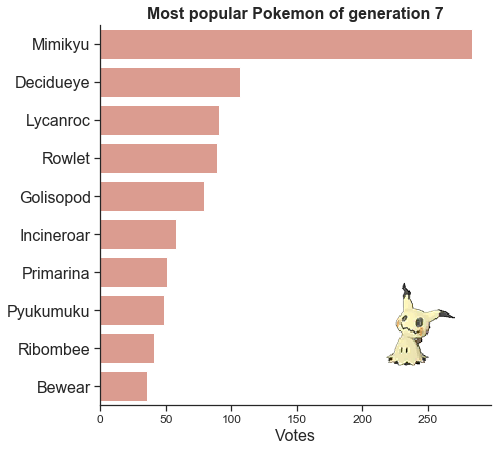

In [28]:
generations = list(df['generation'].unique().astype(int))
generations.insert(0, 'all')

for generation in generations:
    if generation == 'all':
        idx = df.groupby('generation')['votes'].transform(max) == df['votes']
        df_generation = df[idx]
        title_str = "each generation"
        file_name = "all_generations"

    else:
        df_temp = df.query('generation == "' + str(generation) + '"')
        df_generation = df_temp.sort_values('votes', ascending=False).head(10)
        title_str = "generation " + str(generation)
        file_name = "generation" + str(generation)
    
    fig, ax = plt.subplots(1, 1, figsize=[7, 7])
    sns.barplot(x=df_generation['votes'], y=df_generation['name'], hue='generation', palette=generation_palette, dodge=False, data=df_generation, ax=ax)
    if generation == 'all':
        ax.legend(frameon=False, loc='lower right').set_title("Generation")
    else:
        # Remove legend.
        ax.get_legend().remove()
        
        # Add sprite of the most popular Pokemon of each type.
        pokemon_image = pokefunctions.get_sprite(df_generation.index[0])
        if pokemon_image != None:
            ax_ins = inset_axes(ax, width=2, height=2, loc='lower right')
            ax_ins.imshow(pokemon_image)
            ax_ins.axis('off')
    
    ax.set_title("Most popular Pokemon of " + title_str, fontdict={'weight':'bold'})
    ax.set_xlabel("Votes")
    ax.set_ylabel("")
    ax.yaxis.set_tick_params(labelsize=16)
    fig.savefig((PATH_IMAGES/(file_name + '.png')), dpi=1000, bbox_inches='tight')
    plt.show()
pass; # Supress plot output.


### Pok&eacute;mon ranking by type
For this, we will need to do a bit of processing. First, we will make sure that each Pok&eacute;mon has unique types (i.e., that its types are not repeated).

In [29]:
def types_unique(types):
    if type(types)==str:
        types_set = set(types.lower().split())
        return ' '.join(types_set)
    else:
        return types
df_sorted['types'] = df_sorted['types'].apply(types_unique)

After that, we will split each type into a different column:

In [30]:
n_types = 3
types_all = df_sorted['types'].str.split(" ", n=n_types, expand = True)

for ii in np.arange(0, n_types):
    column_name = 'type' + str(ii+1)
    df_sorted[column_name] = types_all[ii]


Now, we can do an analysis per type. Consider that Alolan versions might have different types for the same Pok&eacute;mon (e.g., Vulpix is fire type, while Alolan Vulpix is ice). In this case, we are considering only the main (i.e., first) type of each Pok&eacute;mon (including its sprite):

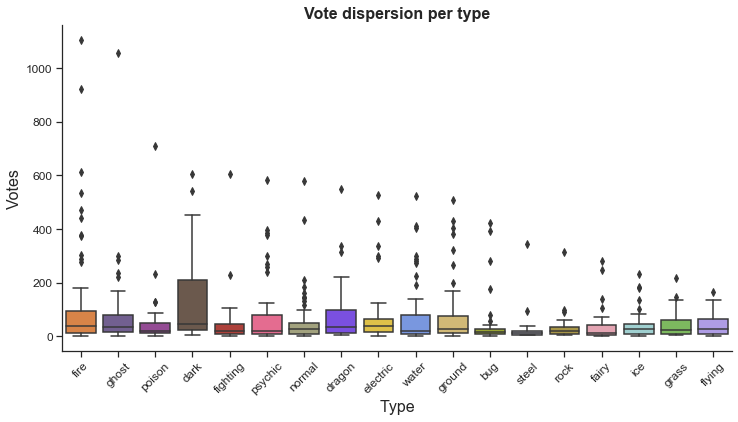

In [31]:
type_palette = {'normal':'#A8A878',
              'fire':'#F08030',
              'fighting':'#C03028',
              'water':'#6890F0',
              'flying':'#A890F0',
              'grass':'#78C850',
              'poison':'#A040A0',
              'electric':'#F8D030',
              'ground':'#E0C068',
              'psychic':'#F85888',
              'rock':'#B8A038',
              'ice':'#98D8D8',
              'bug':'#A8B820',
              'dragon':'#7038F8',
              'ghost':'#705898',
              'dark':'#705848',
              'steel':'#B8B8D0',
              'fairy':'#EE99AC'}

fig, ax = plt.subplots(1, 1, figsize=[12, 6])
sns.boxplot(x='type1', y='votes', data=df_sorted, ax=ax, palette=type_palette)
ax.set_title("Vote dispersion per type", fontdict = {'weight':'bold'})
ax.set_xlabel("Type")
ax.set_ylabel("Votes")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig.savefig(PATH_IMAGES/'type_boxplot.png', dpi=1000, bbox_inches='tight')
plt.show();

In this case, we are considering *all* the types of a Pok&eacute;mon:

,name,votes,types,generation,family,type1,type2,type3
6,Charizard,1107.0,fire flying dragon,1,Charmander,fire,flying,dragon
59,Arcanine,923.0,fire,1,Growlithe,fire,None,None
257,Blaziken,613.0,fire fighting,3,Torchic,fire,fighting,None
157,Typhlosion,534.0,fire,2,Cyndaquil,fire,None,None
38,Ninetales,471.0,fire ice fairy,1,Vulpix,fire,ice,fairy
392,Infernape,443.0,fire fighting,4,Chimchar,fire,fighting,None
155,Cyndaquil,377.0,fire,2,Cyndaquil,fire,None,None
4,Charmander,374.0,fire,1,Charmander,fire,None,None
37,Vulpix,302.0,fire ice,1,Vulpix,fire,ice,None
637,Volcarona,290.0,fire bug,5,Larvesta,fire,bug,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular fire Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

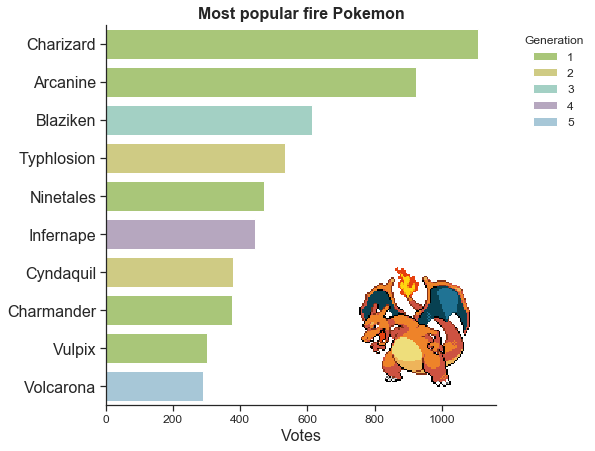

,name,votes,types,generation,family,type1,type2,type3
94,Gengar,1056.0,ghost poison,1,Gastly,ghost,poison,None
93,Haunter,301.0,ghost poison,1,Gastly,ghost,poison,None
778,Mimikyu,284.0,ghost fairy,7,Mimikyu,ghost,fairy,None
302,Sableye,237.0,ghost dark,3,Sableye,ghost,dark,None
609,Chandelure,222.0,ghost fire,5,Litwick,ghost,fire,None
681,Aegislash,168.0,ghost steel,6,Honedge,ghost,steel,None
487,Giratina,157.0,ghost dragon,4,Giratina,ghost,dragon,None
478,Froslass,143.0,ghost ice,4,Snorunt,ghost,ice,None
292,Shedinja,116.0,ghost bug,3,Nincada,ghost,bug,None
724,Decidueye,107.0,ghost grass,7,Rowlet,ghost,grass,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular ghost Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

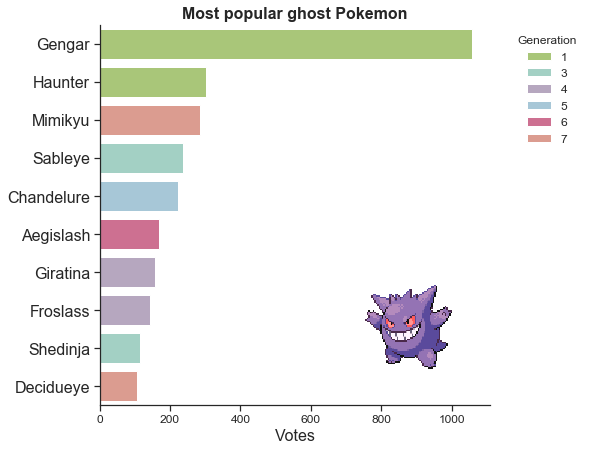

,name,votes,types,generation,family,type1,type2,type3
94,Gengar,1056.0,ghost poison,1,Gastly,ghost,poison,None
1,Bulbasaur,710.0,poison grass,1,Bulbasaur,poison,grass,None
93,Haunter,301.0,ghost poison,1,Gastly,ghost,poison,None
34,Nidoking,265.0,ground poison,1,Nidoran-M,ground,poison,None
169,Crobat,231.0,poison flying,2,Zubat,poison,flying,None
3,Venusaur,127.0,poison grass,1,Bulbasaur,poison,grass,None
43,Oddish,127.0,poison grass,1,Oddish,poison,grass,None
89,Muk,86.0,poison dark,1,Grimer,poison,dark,None
407,Roserade,86.0,poison grass,4,Budew,poison,grass,None
15,Beedrill,83.0,poison bug,1,Weedle,poison,bug,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular poison Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

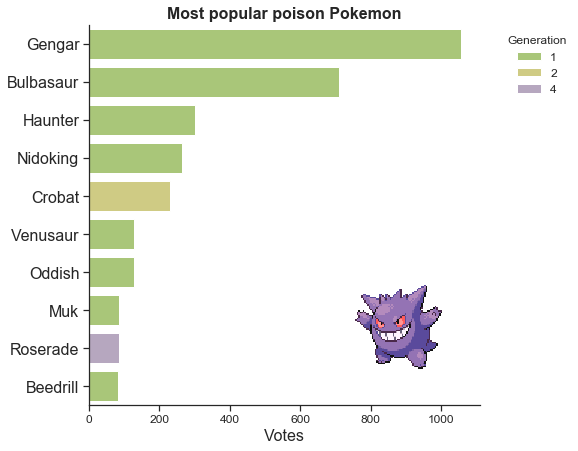

,name,votes,types,generation,family,type1,type2,type3
197,Umbreon,607.0,dark,2,Eevee,dark,None,None
359,Absol,542.0,dark,3,Absol,dark,None,None
248,Tyranitar,451.0,dark rock,2,Larvitar,dark,rock,None
130,Gyarados,265.0,dark flying water,1,Magikarp,dark,flying,water
302,Sableye,237.0,ghost dark,3,Sableye,ghost,dark,None
658,Greninja,219.0,dark water,6,Froakie,dark,water,None
491,Darkrai,185.0,dark,4,Darkrai,dark,None,None
461,Weavile,185.0,ice dark,4,Sneasel,ice,dark,None
229,Houndoom,177.0,fire dark,2,Houndour,fire,dark,None
635,Hydreigon,166.0,dragon dark,5,Deino,dragon,dark,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular dark Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

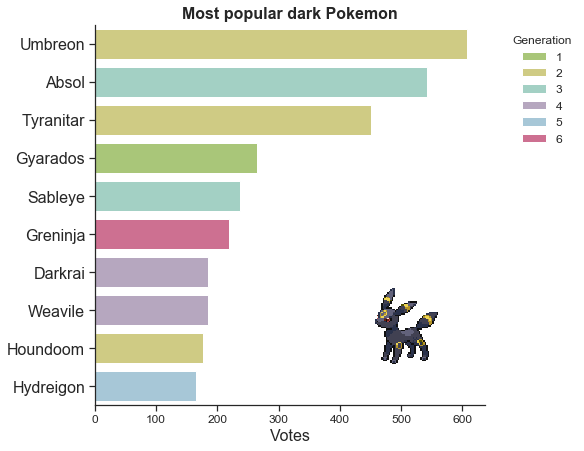

,name,votes,types,generation,family,type1,type2,type3
257,Blaziken,613.0,fire fighting,3,Torchic,fire,fighting,None
448,Lucario,604.0,fighting steel,4,Riolu,fighting,steel,None
392,Infernape,443.0,fire fighting,4,Chimchar,fire,fighting,None
150,Mewtwo,298.0,psychic fighting,1,Mewtwo,psychic,fighting,None
214,Heracross,279.0,bug fighting,2,Heracross,bug,fighting,None
475,Gallade,239.0,psychic fighting,4,Ralts,psychic,fighting,None
286,Breloom,228.0,fighting grass,3,Shroomish,fighting,grass,None
68,Machamp,104.0,fighting,1,Machop,fighting,None,None
454,Toxicroak,82.0,poison fighting,4,Croagunk,poison,fighting,None
428,Lopunny,81.0,normal fighting,4,Buneary,normal,fighting,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular fighting Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

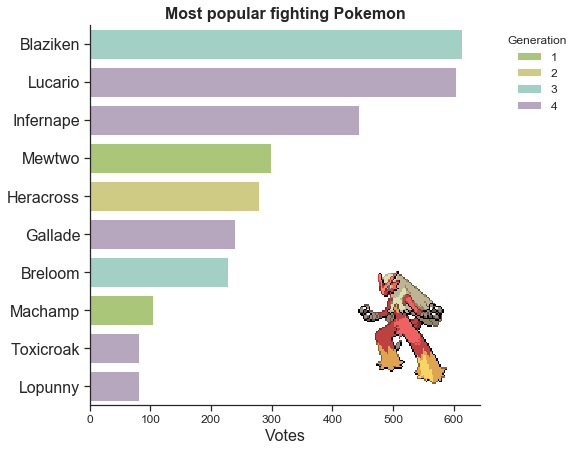

,name,votes,types,generation,family,type1,type2,type3
282,Gardevoir,585.0,psychic fairy,3,Ralts,psychic,fairy,None
376,Metagross,395.0,psychic steel,3,Beldum,psychic,steel,None
196,Espeon,384.0,psychic,2,Eevee,psychic,None,None
65,Alakazam,376.0,psychic,1,Abra,psychic,None,None
26,Raichu,301.0,electric psychic,1,Pichu,electric,psychic,None
150,Mewtwo,298.0,psychic fighting,1,Mewtwo,psychic,fighting,None
151,Mew,269.0,psychic,1,Mew,psychic,None,None
249,Lugia,260.0,psychic flying,2,Lugia,psychic,flying,None
475,Gallade,239.0,psychic fighting,4,Ralts,psychic,fighting,None
385,Jirachi,123.0,psychic steel,3,Jirachi,psychic,steel,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular psychic Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

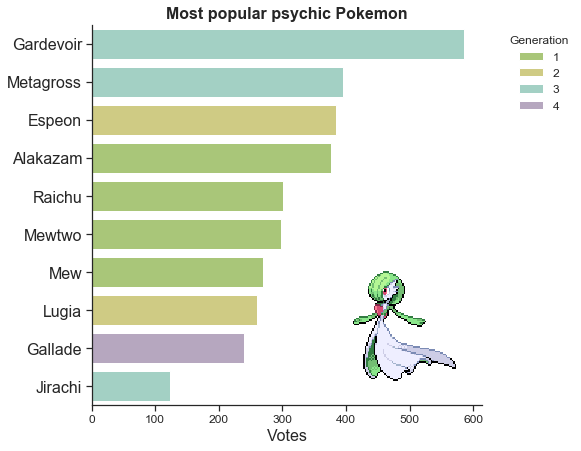

,name,votes,types,generation,family,type1,type2,type3
133,Eevee,581.0,normal,1,Eevee,normal,None,None
143,Snorlax,433.0,normal,1,Munchlax,normal,None,None
206,Dunsparce,209.0,normal,2,Dunsparce,normal,None,None
132,Ditto,184.0,normal,1,Ditto,normal,None,None
39,Jigglypuff,162.0,normal fairy,1,Igglybuff,normal,fairy,None
474,Porygon-Z,148.0,normal,4,Porygon,normal,None,None
398,Staraptor,142.0,normal flying,4,Starly,normal,flying,None
162,Furret,132.0,normal,2,Sentret,normal,None,None
83,Farfetchd,118.0,normal flying,1,Farfetchd,normal,flying,None
335,Zangoose,99.0,normal,3,Zangoose,normal,None,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular normal Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

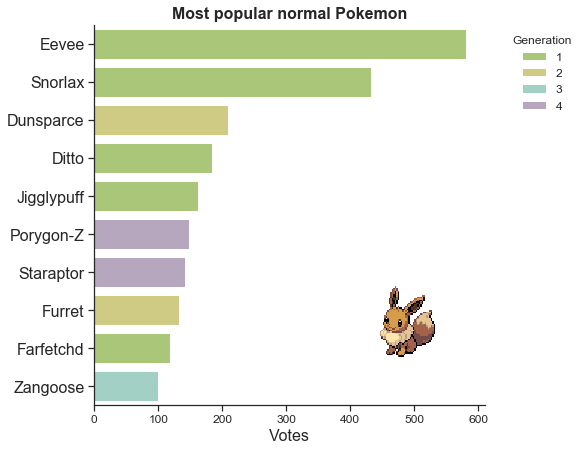

,name,votes,types,generation,family,type1,type2,type3
6,Charizard,1107.0,fire flying dragon,1,Charmander,fire,flying,dragon
149,Dragonite,551.0,dragon flying,1,Dratini,dragon,flying,None
181,Ampharos,529.0,electric dragon,2,Mareep,electric,dragon,None
330,Flygon,510.0,ground dragon,3,Trapinch,ground,dragon,None
445,Garchomp,404.0,ground dragon,4,Gible,ground,dragon,None
254,Sceptile,337.0,dragon grass,3,Treecko,dragon,grass,None
384,Rayquaza,316.0,dragon flying,3,Rayquaza,dragon,flying,None
373,Salamence,220.0,dragon flying,3,Bagon,dragon,flying,None
635,Hydreigon,166.0,dragon dark,5,Deino,dragon,dark,None
487,Giratina,157.0,ghost dragon,4,Giratina,ghost,dragon,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular dragon Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

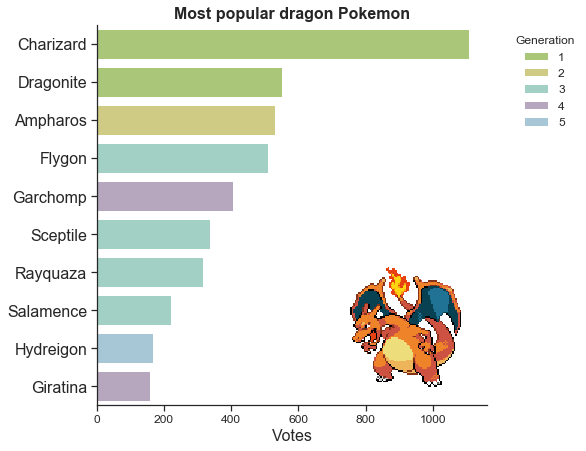

,name,votes,types,generation,family,type1,type2,type3
181,Ampharos,529.0,electric dragon,2,Mareep,electric,dragon,None
405,Luxray,429.0,electric,4,Shinx,electric,None,None
135,Jolteon,335.0,electric,1,Eevee,electric,None,None
26,Raichu,301.0,electric psychic,1,Pichu,electric,psychic,None
25,Pikachu,293.0,electric,1,Pichu,electric,None,None
403,Shinx,124.0,electric,4,Shinx,electric,None,None
145,Zapdos,121.0,electric flying,1,Zapdos,electric,flying,None
179,Mareep,118.0,electric,2,Mareep,electric,None,None
596,Galvantula,117.0,electric bug,5,Joltik,electric,bug,None
466,Electivire,113.0,electric,4,Elekid,electric,None,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular electric Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

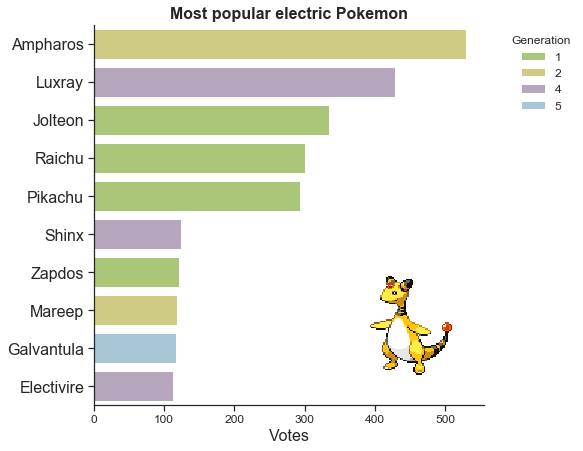

,name,votes,types,generation,family,type1,type2,type3
7,Squirtle,523.0,water,1,Squirtle,water,None,None
9,Blastoise,410.0,water,1,Squirtle,water,None,None
258,Mudkip,404.0,water,3,Mudkip,water,None,None
260,Swampert,381.0,ground water,3,Mudkip,ground,water,None
395,Empoleon,346.0,steel water,4,Piplup,steel,water,None
158,Totodile,300.0,water,2,Totodile,water,None,None
160,Feraligatr,287.0,water,2,Totodile,water,None,None
54,Psyduck,281.0,water,1,Psyduck,water,None,None
134,Vaporeon,275.0,water,1,Eevee,water,None,None
130,Gyarados,265.0,dark flying water,1,Magikarp,dark,flying,water


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular water Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

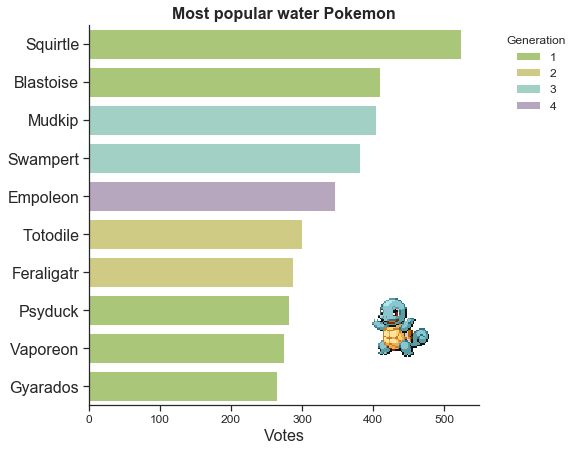

,name,votes,types,generation,family,type1,type2,type3
330,Flygon,510.0,ground dragon,3,Trapinch,ground,dragon,None
389,Torterra,430.0,ground grass,4,Turtwig,ground,grass,None
445,Garchomp,404.0,ground dragon,4,Gible,ground,dragon,None
260,Swampert,381.0,ground water,3,Mudkip,ground,water,None
104,Cubone,321.0,ground,1,Cubone,ground,None,None
34,Nidoking,265.0,ground poison,1,Nidoran-M,ground,poison,None
27,Sandshrew,200.0,ground ice steel,1,Sandshrew,ground,ice,steel
28,Sandslash,167.0,ground ice steel,1,Sandshrew,ground,ice,steel
472,Gliscor,132.0,ground flying,4,Gligar,ground,flying,None
195,Quagsire,123.0,ground water,2,Wooper,ground,water,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular ground Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

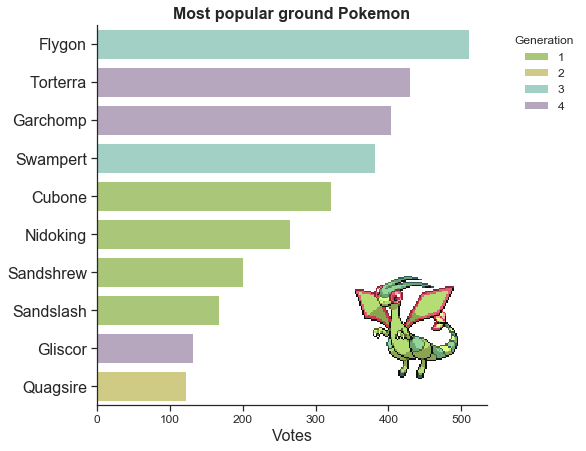

,name,votes,types,generation,family,type1,type2,type3
212,Scizor,424.0,bug steel,2,Scyther,bug,steel,None
123,Scyther,394.0,bug flying,1,Scyther,bug,flying,None
637,Volcarona,290.0,fire bug,5,Larvesta,fire,bug,None
214,Heracross,279.0,bug fighting,2,Heracross,bug,fighting,None
213,Shuckle,176.0,bug rock,2,Shuckle,bug,rock,None
596,Galvantula,117.0,electric bug,5,Joltik,electric,bug,None
292,Shedinja,116.0,ghost bug,3,Nincada,ghost,bug,None
15,Beedrill,83.0,poison bug,1,Weedle,poison,bug,None
545,Scolipede,80.0,poison bug,5,Venipede,poison,bug,None
768,Golisopod,79.0,bug water,7,Wimpod,bug,water,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular bug Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

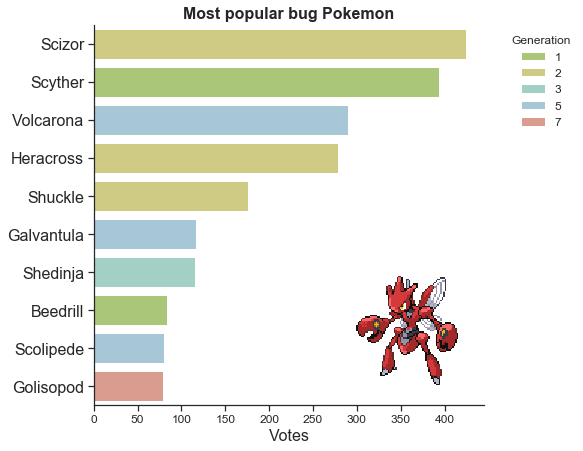

,name,votes,types,generation,family,type1,type2,type3
448,Lucario,604.0,fighting steel,4,Riolu,fighting,steel,None
212,Scizor,424.0,bug steel,2,Scyther,bug,steel,None
376,Metagross,395.0,psychic steel,3,Beldum,psychic,steel,None
395,Empoleon,346.0,steel water,4,Piplup,steel,water,None
306,Aggron,313.0,rock steel,3,Aron,rock,steel,None
303,Mawile,247.0,fairy steel,3,Mawile,fairy,steel,None
27,Sandshrew,200.0,ground ice steel,1,Sandshrew,ground,ice,steel
681,Aegislash,168.0,ghost steel,6,Honedge,ghost,steel,None
28,Sandslash,167.0,ground ice steel,1,Sandshrew,ground,ice,steel
227,Skarmory,135.0,flying steel,2,Skarmory,flying,steel,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular steel Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

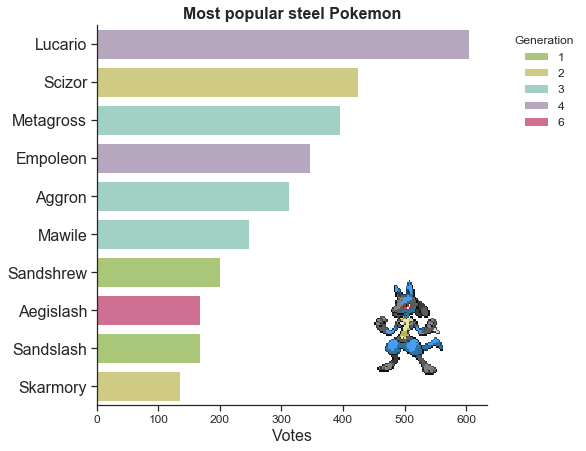

,name,votes,types,generation,family,type1,type2,type3
248,Tyranitar,451.0,dark rock,2,Larvitar,dark,rock,None
306,Aggron,313.0,rock steel,3,Aron,rock,steel,None
213,Shuckle,176.0,bug rock,2,Shuckle,bug,rock,None
141,Kabutops,118.0,water rock,1,Kabuto,water,rock,None
304,Aron,96.0,rock steel,3,Aron,rock,steel,None
745,Lycanroc,91.0,rock,7,Rockruff,rock,None,None
697,Tyrantrum,73.0,dragon rock,6,Tyrunt,dragon,rock,None
185,Sudowoodo,60.0,rock,2,Bonsly,rock,None,None
142,Aerodactyl,51.0,flying rock,1,Aerodactyl,flying,rock,None
246,Larvitar,50.0,ground rock,2,Larvitar,ground,rock,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular rock Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

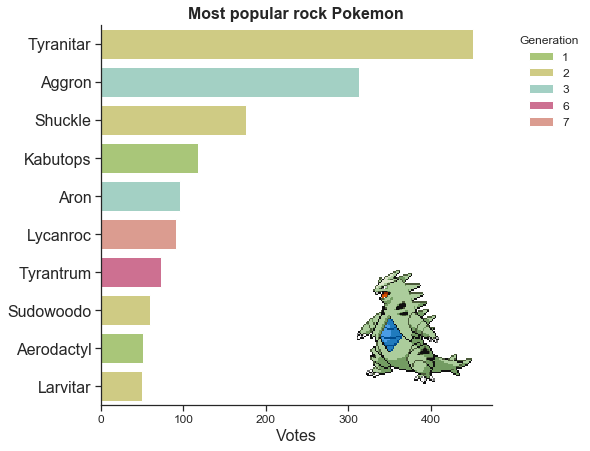

,name,votes,types,generation,family,type1,type2,type3
282,Gardevoir,585.0,psychic fairy,3,Ralts,psychic,fairy,None
38,Ninetales,471.0,fire ice fairy,1,Vulpix,fire,ice,fairy
778,Mimikyu,284.0,ghost fairy,7,Mimikyu,ghost,fairy,None
700,Sylveon,282.0,fairy,6,Eevee,fairy,None,None
303,Mawile,247.0,fairy steel,3,Mawile,fairy,steel,None
468,Togekiss,164.0,flying fairy,4,Togepi,flying,fairy,None
39,Jigglypuff,162.0,normal fairy,1,Igglybuff,normal,fairy,None
547,Whimsicott,139.0,fairy grass,5,Cottonee,fairy,grass,None
334,Altaria,136.0,dragon flying fairy,3,Swablu,dragon,flying,fairy
184,Azumarill,106.0,fairy water,2,Azurill,fairy,water,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular fairy Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

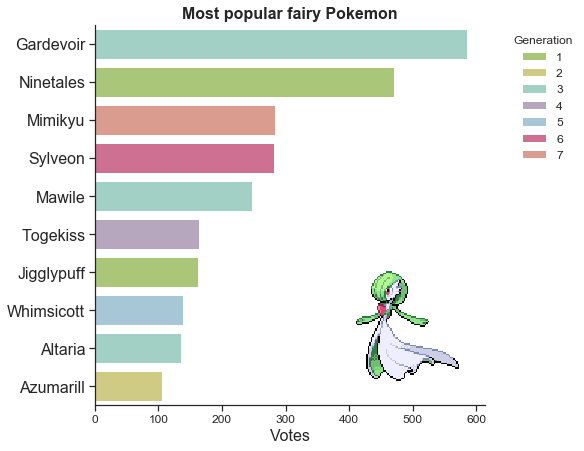

,name,votes,types,generation,family,type1,type2,type3
38,Ninetales,471.0,fire ice fairy,1,Vulpix,fire,ice,fairy
37,Vulpix,302.0,fire ice,1,Vulpix,fire,ice,None
131,Lapras,233.0,ice water,1,Lapras,ice,water,None
27,Sandshrew,200.0,ground ice steel,1,Sandshrew,ground,ice,steel
461,Weavile,185.0,ice dark,4,Sneasel,ice,dark,None
471,Glaceon,180.0,ice,4,Eevee,ice,None,None
28,Sandslash,167.0,ground ice steel,1,Sandshrew,ground,ice,steel
478,Froslass,143.0,ghost ice,4,Snorunt,ghost,ice,None
144,Articuno,136.0,ice flying,1,Articuno,ice,flying,None
215,Sneasel,103.0,ice dark,2,Sneasel,ice,dark,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular ice Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

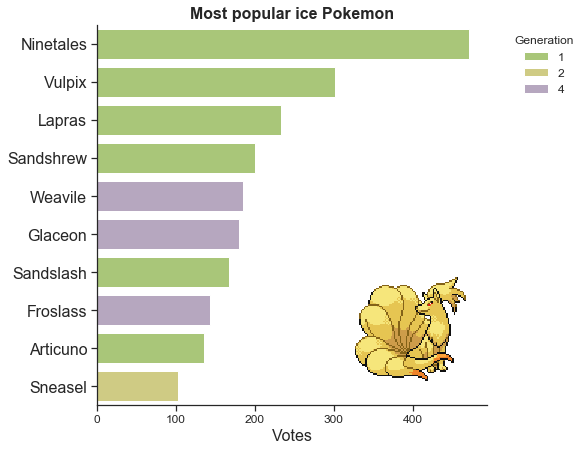

,name,votes,types,generation,family,type1,type2,type3
1,Bulbasaur,710.0,poison grass,1,Bulbasaur,poison,grass,None
389,Torterra,430.0,ground grass,4,Turtwig,ground,grass,None
254,Sceptile,337.0,dragon grass,3,Treecko,dragon,grass,None
286,Breloom,228.0,fighting grass,3,Shroomish,fighting,grass,None
387,Turtwig,218.0,grass,4,Turtwig,grass,None,None
272,Ludicolo,147.0,grass water,3,Lotad,grass,water,None
547,Whimsicott,139.0,fairy grass,5,Cottonee,fairy,grass,None
252,Treecko,134.0,grass,3,Treecko,grass,None,None
253,Grovyle,129.0,grass,3,Treecko,grass,None,None
3,Venusaur,127.0,poison grass,1,Bulbasaur,poison,grass,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular grass Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

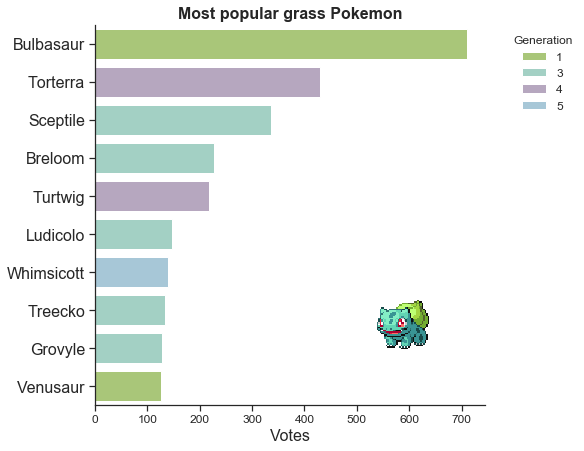

,name,votes,types,generation,family,type1,type2,type3
6,Charizard,1107.0,fire flying dragon,1,Charmander,fire,flying,dragon
149,Dragonite,551.0,dragon flying,1,Dratini,dragon,flying,None
123,Scyther,394.0,bug flying,1,Scyther,bug,flying,None
384,Rayquaza,316.0,dragon flying,3,Rayquaza,dragon,flying,None
130,Gyarados,265.0,dark flying water,1,Magikarp,dark,flying,water
249,Lugia,260.0,psychic flying,2,Lugia,psychic,flying,None
169,Crobat,231.0,poison flying,2,Zubat,poison,flying,None
373,Salamence,220.0,dragon flying,3,Bagon,dragon,flying,None
468,Togekiss,164.0,flying fairy,4,Togepi,flying,fairy,None
398,Staraptor,142.0,normal flying,4,Starly,normal,flying,None


(-0.5, 95.5, 95.5, -0.5)

Text(0.5, 1.0, 'Most popular flying Pokemon')

Text(0.5, 0, 'Votes')

Text(0, 0.5, '')

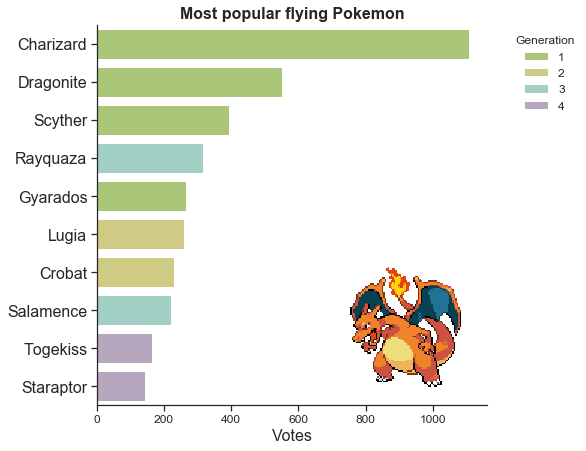

In [32]:
types = df_sorted['type1'].unique()

for pokemon_type in types:
    df_temp = df_sorted.query('type1=="' + pokemon_type + '" | type2=="' + pokemon_type + '" | type3=="' + pokemon_type + '"')
    df_temp.head(10)
    
    fig, ax = plt.subplots(1, 1, figsize=[7, 7])
    sns.barplot(x=df_temp.head(10)['votes'], y=df_temp.head(10)['name'], hue='generation', palette=generation_palette, dodge=False, data=df_temp.head(10), ax=ax)
    
    # Add sprite of the most popular Pokemon of each type.
    pokemon_image = pokefunctions.get_sprite(df_temp.index[0])
    if pokemon_image != None:
        ax_ins = inset_axes(ax, width=2, height=2, loc='lower right')
        ax_ins.imshow(pokemon_image)
        ax_ins.axis('off')

    ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.25, 1)).set_title("Generation")
    ax.set_title("Most popular " + pokemon_type + " Pokemon", fontdict={'weight':'bold'})
    ax.set_xlabel("Votes")
    ax.set_ylabel("")
    ax.yaxis.set_tick_params(labelsize=16)
    fig.savefig(PATH_IMAGES/(pokemon_type + '.png'), dpi=1000, bbox_inches='tight')
    plt.show()
pass; # Supress plot output.

### Least loved Pok&eacute;mon
The least popular Pok&eacute;mon. Those who received 0 votes:

In [21]:
df_sorted.query('votes == 0')

,name,votes,types,generation,family,type1,type2,type3
574,Gothita,0.0,psychic,5,Gothita,psychic,None,None
603,Eelektrik,0.0,electric,5,Tynamo,electric,None,None
266,Silcoon,0.0,bug,3,Wurmple,bug,None,None
734,Yungoos,0.0,normal,7,Yungoos,normal,None,None


...and those who received 1 vote:

In [22]:
df_sorted.query('votes == 1')

,name,votes,types,generation,family,type1,type2,type3
540,Sewaddle,1.0,bug grass,5,Sewaddle,bug,grass,None
594,Alomomola,1.0,water,5,Alomomola,water,None,None
790,Cosmoem,1.0,psychic,7,Cosmog,psychic,None,None
343,Baltoy,1.0,ground psychic,3,Baltoy,ground,psychic,None
451,Skorupi,1.0,bug poison,4,Skorupi,bug,poison,None
732,Trumbeak,1.0,flying normal,7,Pikipek,flying,normal,None
102,Exeggcute,1.0,grass psychic,1,Exeggcute,grass,psychic,None
504,Patrat,1.0,normal,5,Patrat,normal,None,None


The bottom 10 (least popular) Pok&eacute;mon *families*:

In [23]:
df[['votes', 'family']].groupby('family').sum().sort_values('votes', ascending=False).tail(10)

# Notice that a similar result could be achieved by using
# df[['votes', 'family']].groupby('family').sum().sort_values('votes', ascending=True).head(10)

,votes
family,
Virizion,4.0
Thundurus,4.0
Uxie,3.0
Terrakion,3.0
Tapu-Bulu,2.0
Tapu-Fini,2.0
Phione,2.0
Tornadus,2.0
Landorus,2.0


### Paretto analysis
`mamamia1001` also generated a plot of the [Paretto principle](https://en.wikipedia.org/wiki/Pareto_principle) (also known as the 80/20 rule). Originally, it states that roughly 80% of the effects (in this case, votes) come from 20% of the causes (in this case, Pok&eacute;mon). Let's obtain such plot. 

First, let's compute the cumulative sum of votes and their corresponding vote percentage for each Pok&eacute;mon:

In [33]:
df_paretto = df_sorted.copy()
df_paretto['votes_cumulative'] = df_sorted['votes'].cumsum()
df_paretto['votes_cumulative_perc'] = (df_paretto['votes_cumulative']/n_votes) * 100

We just need to generate a few auxiliary variables to generate the plot:

In [34]:
df_paretto['pokemon_perc'] = (np.arange(1, n_pokemon+1)/n_pokemon)*100

# Find the index of the Pokemon corresponding to the 20% of the Pokemon.
index_pokemon_20 = abs(df_paretto['pokemon_perc'] - 20).idxmin()

# Find the index and value of the Pokemon corresponding to the 80% of the votes.
pokemon_votes_80_idx = abs(df_paretto['votes_cumulative_perc'] - 80).idxmin()
pokemon_votes_80 = df_paretto.loc[pokemon_votes_80_idx, 'pokemon_perc']

# Find the index and value of the votes corresponding to the 20% of the Pokemon
votes_pokemon_20_idx = abs(df_paretto['pokemon_perc'] - 20).idxmin()
votes_pokemon_20 = df_paretto.loc[votes_pokemon_20_idx, 'votes_cumulative_perc']

# Find the index of the votes corresponding to the 80% of the votes.
index_votes_80 = abs(df_paretto['votes_cumulative_perc'] - 80).idxmin()


Actually generate the Paretto plot:

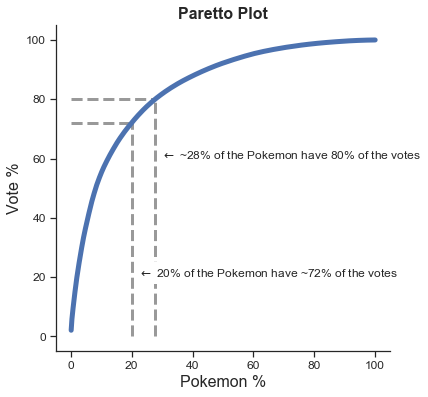

In [35]:
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.plot(df_paretto['pokemon_perc'], df_paretto['votes_cumulative_perc'], linewidth=5)

plt.hlines(80, 0, pokemon_votes_80, linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])
plt.hlines(votes_pokemon_20, 0, df_paretto.loc[index_pokemon_20, 'pokemon_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])

plt.vlines(20, 0, df_paretto.loc[index_pokemon_20, 'votes_cumulative_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])
plt.vlines(df_paretto.loc[index_votes_80, 'pokemon_perc'], 0, df_paretto.loc[index_votes_80, 'votes_cumulative_perc'], linewidth=3, linestyles='dashed', colors=[0.6, 0.6, 0.6])

plt.text(22, 20, r"$\leftarrow$ 20% of the Pokemon have ~{0:.0f}% of the votes".format(votes_pokemon_20), fontsize=12, backgroundcolor='w')
plt.text(pokemon_votes_80+2, 60, r"$\leftarrow$ ~{0:.0f}% of the Pokemon have 80% of the votes".format(pokemon_votes_80), fontsize=12, backgroundcolor='w')

ax.set_title("Paretto Plot", fontdict = {'fontsize':16, 'fontweight':'bold'})
ax.set_xlabel("Pokemon %", fontdict = {'fontsize':16})
ax.set_ylabel("Vote %", fontdict = {'fontsize':16})

fig.savefig(PATH_IMAGES/'paretto.png', dpi=1000, bbox_inches='tight')

plt.show();

# New Analysis
Alright, time to go to uncharted territory. Fasten your Pok&eacute;seat belts.

### Votes in time
First, I would like to look at how people voted in time overall and for each of the top Pok&eacute;mon:

In [37]:
df_raw = pd.read_excel(PATH_DATA/'responses.xlsx', sheet_name='Form Responses 1')
df_raw.rename(columns={'Timestamp':'timestamp', 'What is your favourite Pokémon?':'vote'}, inplace=True)

# Remove any potential NaN.
df_raw.dropna(inplace=True)

df_raw.head(3)

,timestamp,vote
0,2019-06-13 13:02:02.242,Munchlax
1,2019-06-13 12:44:00.726,Type-Null
2,2019-06-13 12:44:45.607,Giratina


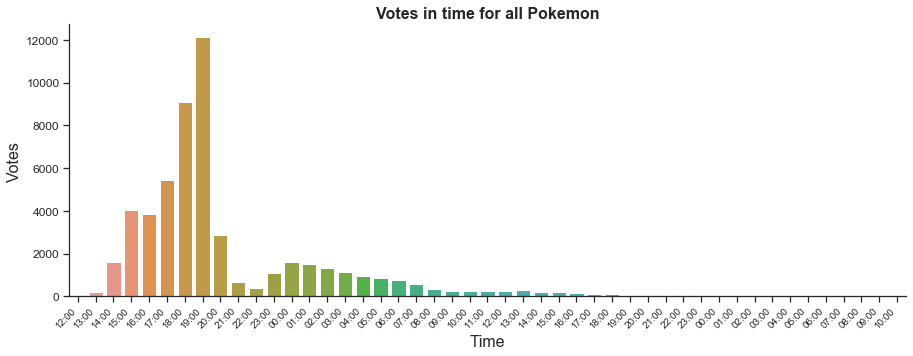

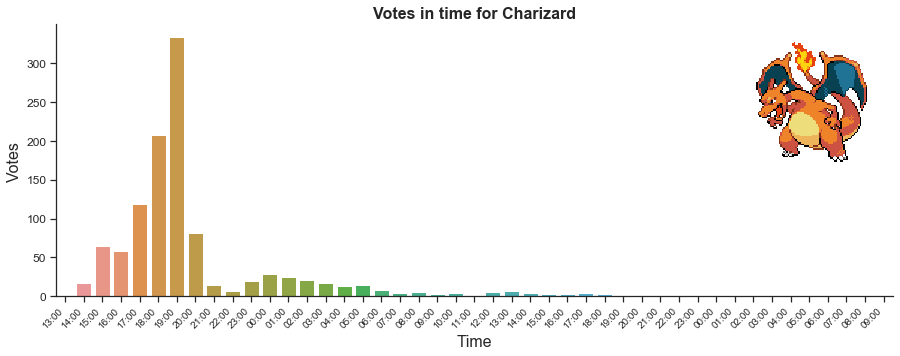

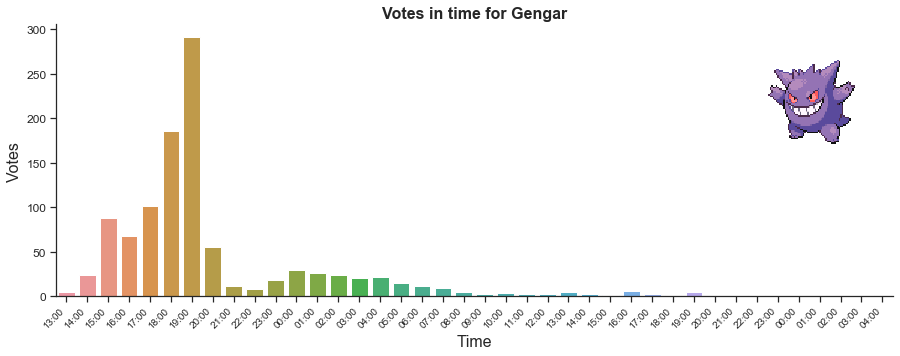

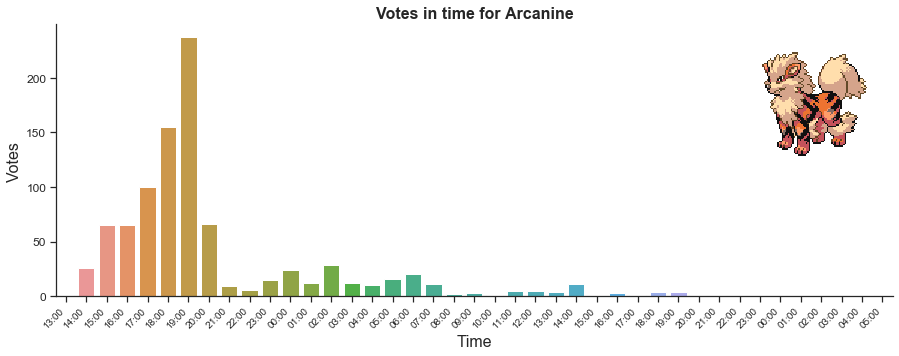

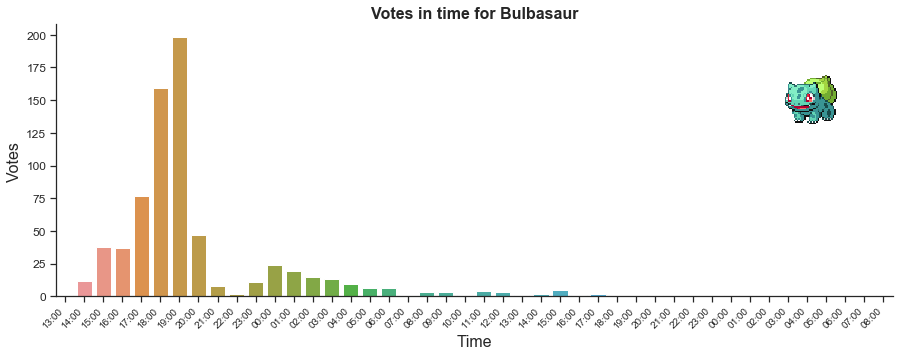

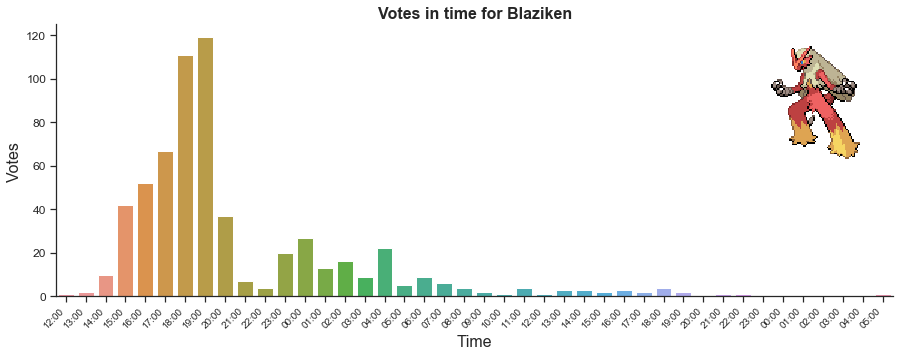

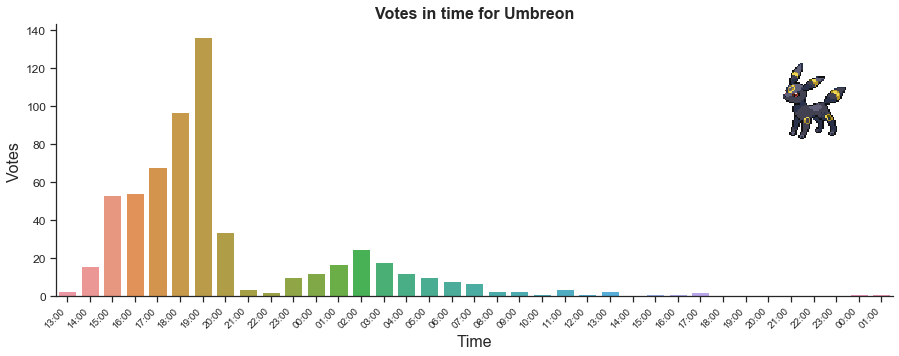

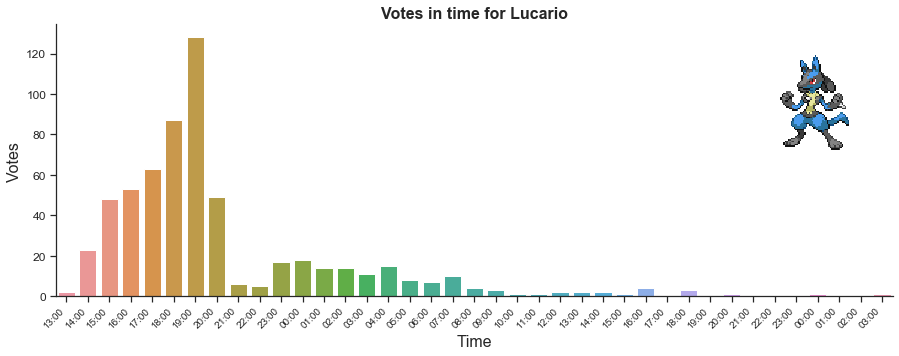

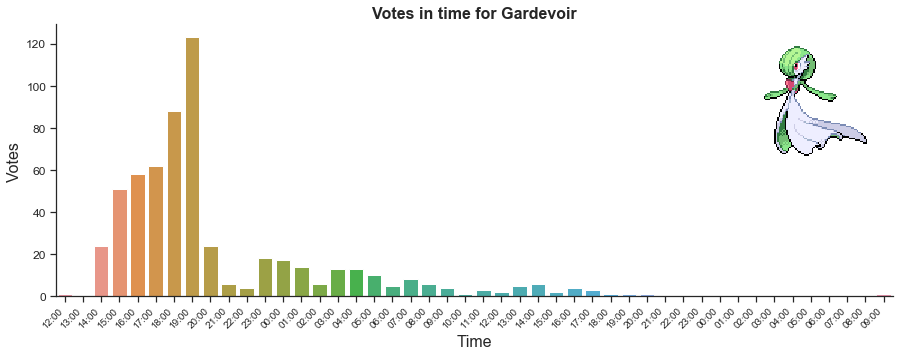

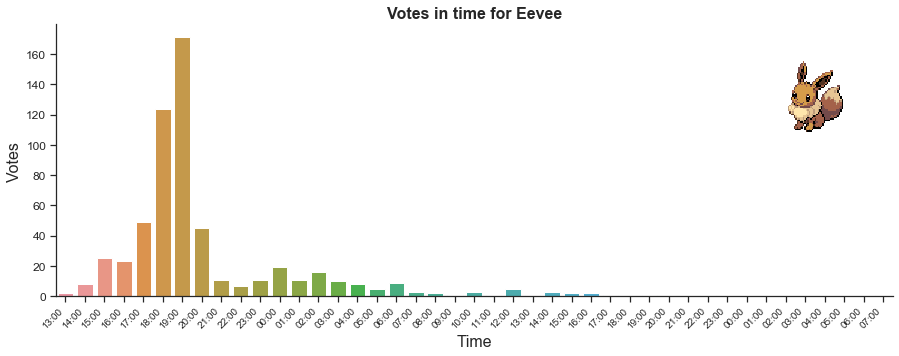

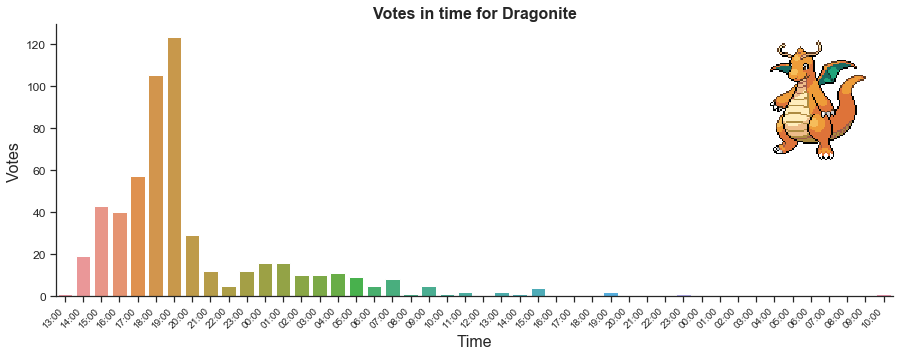

In [41]:
pokemon_time = list(df_sorted.head(10)['name'])
pokemon_number_time = list(df_sorted.head(10).index)

pokemon_time.insert(0, 'all')
pokemon_number_time.insert(0, 0)

for pokemon, pokemon_number in zip(pokemon_time, pokemon_number_time):
    
    if pokemon == 'all':
        df_temp = df_raw.copy(deep=True)
        title_str = "all Pokemon"
        file_name = 'time_all'
        
    else:
        df_temp = df_raw.query('vote=="' + pokemon + '"')
        title_str = pokemon
        file_name = 'time_' + pokemon
        
    df_time = df_temp.groupby(pd.Grouper(key='timestamp', freq='1h')).count()
    df_time['timestamp'] = df_time.index

    x_times = df_time['timestamp'].dt.strftime('%H:%M')
                   
    fig, ax = plt.subplots(1, 1, figsize=[15, 5])
    sns.barplot(x='timestamp', y='vote', data=df_time, ax=ax)
    ax.set_title("Votes in time for " + title_str, fontdict={'weight':'bold'})
    ax.set_xticklabels(labels=x_times, rotation=45, ha='right', fontdict = {'fontsize':10})
    ax.set_xlabel("Time")
    ax.set_ylabel("Votes")
    
    # If the plot correspond to a specific Pokemon, include its image.
    if pokemon_number != 0:
        pokemon_image = pokefunctions.get_sprite(pokemon_number)
        if pokemon_image != None:
            ax_ins = inset_axes(ax, width=2, height=2, loc='upper right')
            ax_ins.imshow(pokemon_image)
            ax_ins.axis('off')
    fig.savefig(PATH_IMAGES/(file_name.lower() + '.png'), dpi=1000, bbox_inches='tight')
    plt.show()
pass; # Supress plot output.

It looks like votes for each of the top Pok&eacute;mon were more or less cast in the same way than for all other Pok&eacute;mon.

### Incorporating Pok&eacute;mon stats
I'm very curious to see if Pok&eacute;mon stats have some influence on their popularity. To do so, I will use ["The Complete Pokemon Dataset"](https://www.kaggle.com/rounakbanik/pokemon) (from Kaggle). You will find the corresponding [.csv file here](../data).

In [29]:
df_stats_ = pd.read_csv(PATH_DATA/'pokemon_stats.csv')
df_stats = df.merge(df_stats_[['pokedex_number', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'height_m', 'weight_kg']], how='left',left_index=True, right_on='pokedex_number')
df_stats['power'] = df_stats['hp'] +  df_stats['attack'] + df_stats['defense'] + df_stats['sp_attack'] + df_stats['sp_defense'] + df_stats['speed']
df_stats.set_index('pokedex_number', inplace=True)

# Generate a reduced dataframe with only numeric values.
df_stats_reduced = df_stats[['votes', 'generation', 'power', 'hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed', 'height_m', 'weight_kg']]
df_stats_reduced.head(5)

,votes,generation,power,hp,attack,defense,sp_attack,sp_defense,speed,height_m,weight_kg
pokedex_number,,,,,,,,,,,
1,710.0,1,318.0,45.0,49.0,49.0,65.0,65.0,45.0,0.7,6.9
2,83.0,1,405.0,60.0,62.0,63.0,80.0,80.0,60.0,1.0,13.0
3,127.0,1,625.0,80.0,100.0,123.0,122.0,120.0,80.0,2.0,100.0
4,374.0,1,309.0,39.0,52.0,43.0,60.0,50.0,65.0,0.6,8.5
5,70.0,1,405.0,58.0,64.0,58.0,80.0,65.0,80.0,1.1,19.0


Let's see if there's a correlation between any of the stats with the votes each Pok&eacute;mon received:

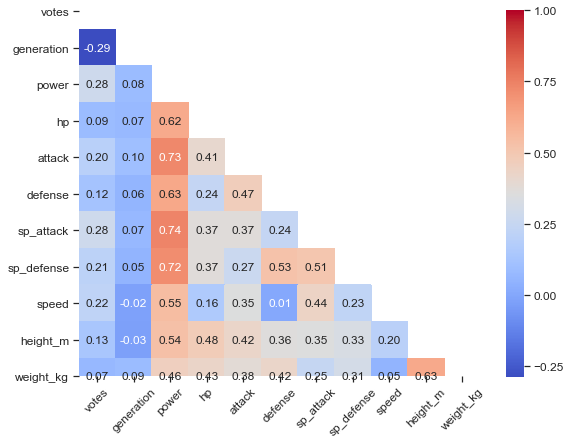

In [30]:
stats_corr = df_stats_reduced.corr(method='pearson')
mask = np.zeros_like(stats_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(1, 1, figsize=[9, 9])
sns.heatmap(stats_corr, annot=True, square=True, fmt= '.2f', cmap='coolwarm', mask=mask, cbar_kws={'shrink':0.75}, ax=ax)
ax.set_xticklabels(ax.get_yticklabels(), rotation=45)
plt.show()

The stats with the highest correlation are power and special attack (both with 0.28) and generation (with -0.29). Since power and special attack are strongly correlated beetween them, we will keep the former for future analysis. The other stats are only (very) weakly correlated with the number of votes.

Let's see how this looks visually with a little bit more of detail:

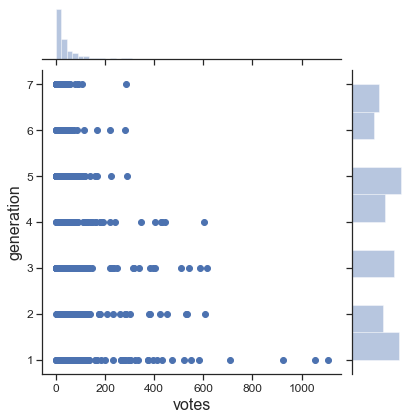

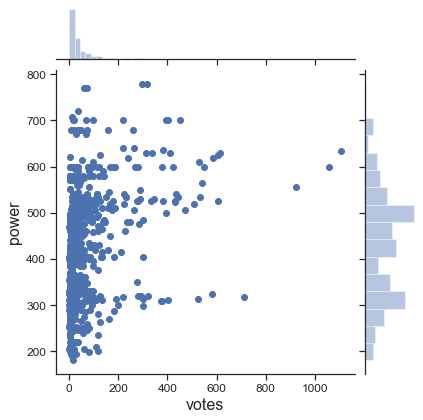

In [31]:
features = ['generation', 'power']
for feature in features:
    g = sns.jointplot('votes', feature, data=df_stats)
    plt.show()

Mmm, it looks like we have a lot of Pok&eacute;mon with low number of votes. Let's convert the votes to a logarithmic scale and do the same analysis:

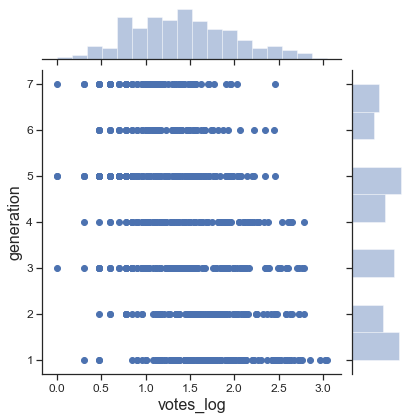

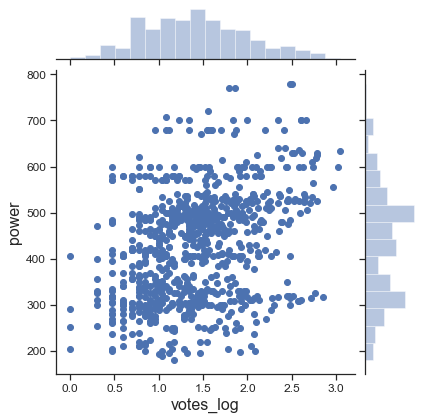

In [32]:
df_stats['votes_log'] = np.log10(df_stats['votes']+1)
features = ['generation', 'power']
for feature in features:
    g = sns.jointplot('votes_log', feature, data=df_stats)
    plt.show()

# Conclusions
There are a few interesting conclusions worth pointing out:
* There were [more votes for Pok&eacute;mon from earlier generations](#Average-votes-per-Pok&eacute;mon-per-generation). This is a very interesting result. Does nostalgia play an important role here? It is hard to say. It would be very interesting to have more information on the voters' profile (e.g., age). For instance, older fans could have more preference for Pok&eacute;mon with which they grew up with. Unfortunately, we don't have those data.
* It is no surprise that the Eevee family is [the most popular Pok&eacute;mon family](#Pok&eacute;mon-ranking-by-family), given that [Eevee is the Pokemon with the most evolutions](https://bulbapedia.bulbagarden.net/wiki/Eeveelution) (plus, let's face it, most of them are quite cool).
* The [Paretto principle](#Paretto-analysis) kinda works in this case: 20% of the Pok&eacute;mon received ~72% of the votes.
* It looks like the [best predictors of Pok&eacute;mon preference are generation and power](#Incorporating-Pok&eacute;mon-stats). Originally, I thought a Pok&eacute;mon's size (i.e., height or weight) could be a factor (maybe larger/smaller Pok&eacute;mon were more popoular because of their imponent/cute appearance), but it doesn't look like it. If we wished to build a model to predict Pok&eacute;mon preference, this would be our starting point (I will probably try to do so in the future!).
* Working with Pok&eacute;mon data is fun :)